# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects _on top_ of existing visibility simulations, it also provides a neat interface to several visibility simulators.

It does so through the base class ``VisibilitySimulator``, which sets a standard API from which all simulators must derive.

## VisCPU

In [5]:
from hera_sim.visibilities import VisCPU, HealVis, PRISim
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import itertools
from pyuvsim.analyticbeam import AnalyticBeam

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def plot_blts(simulator):
    fig, ax = plt.subplots(2, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"})

    for i in simulator.uvdata.antenna_numbers:
        auto_ind = simulator.uvdata.antpair2ind((i,i))

        ax[0].plot(np.unique(simulator.uvdata.lst_array)*12/np.pi, 
                   np.abs(simulator.uvdata.data_array[auto_ind, 0, 0, 0]), label="ant_{}".format(i))

        for j in simulator.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator.uvdata.antpair2ind((i,j))
            ax[1].plot(np.unique(simulator.uvdata.lst_array)*12/np.pi, np.abs(simulator.uvdata.data_array[cross_ind, 0, 0, 0]), label="bl({},{})".format(i,j))

    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[1].set_xlabel("LST (hours)");

``VisCPU`` natively deals with diffuse emission, and the ``VisibilitySimulator`` uses ``healpix`` maps to represent such emission:

In [7]:
def uniform_sky(nside_base=5, scale=1, nfreqs=5):
    NSIDE = 2**nside_base
    NPIX = 12 * NSIDE**2 # this is the number of pixels a healpix map has for  given NSIDE

    # Create a sky of purely ones, multiply by "scale"
    return scale* np.ones((nfreqs, NPIX))/NPIX

Other than the sky model (we'll revisit this soon), the ``VisibilitySimulator`` requires a ``UVData`` object to specify the observation parameters, as well as a list of ``UVBeam``s to specify the beams for each antenna. This makes it fully consistent with the interface provided by ``pyuvsim``, and many of the methods found in ``pyuvsim`` for creating ``UVData`` objects and ``UVBeam`` objects from YAML specifications can be used here. Indeed, a dictionary of so-called ``obsparams``, or a file-name for an appropriate YAML file, can be passed in lieu of the ``UVData`` and ``UVBeam``. 

For simplicity, let us simply use the native ``empty_uvdata`` function instead:

In [8]:
def myuvdata():
    return io.empty_uvdata(
        nfreq = 5,
        time_per_integ = 1800.0,
        ntimes= 48,
        ants = {
            0: (0,0,0),
            1: (20,20,0),
            2: (-20,20,0),
        },
        antpairs = sum([[(a,b) for a in range(3)] for b in range(3)], [])
    )

freqs = np.unique(myuvdata().freq_array)

In [9]:
simulator = VisCPU(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(5),
    sky_freqs = freqs,
    bm_pix=101,
)

invalid value encountered in sqrt


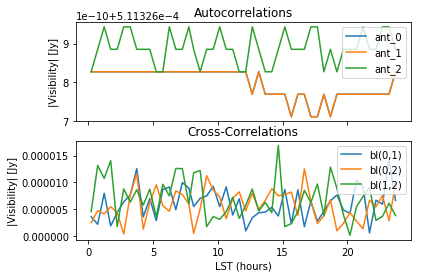

In [10]:
vis = simulator.simulate()
plot_blts(simulator)

Test whether increasing the number of pixels changes much

In [11]:
simulator = VisCPU(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(6),
    sky_freqs = freqs,
)

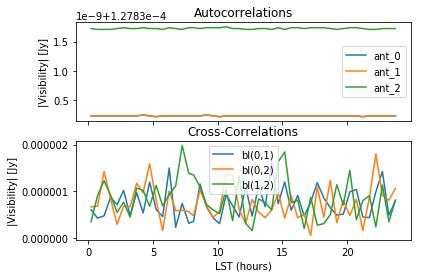

In [12]:
vis = simulator.simulate()
plot_blts(simulator)

### Point Sources

In [13]:
point_source_pos = np.array([(0, myuvdata().telescope_lat_lon_alt[0].value)]) # ra, dec)
point_source_flx = np.array([[1.0]*len(freqs)]).T

AttributeError: 'float' object has no attribute 'value'

In [14]:
simulator = VisCPU(
    uvdata = myuvdata(),
    point_source_pos=point_source_pos,
    point_source_flux = point_source_flx,
    sky_freqs = freqs,
)

NameError: name 'point_source_pos' is not defined

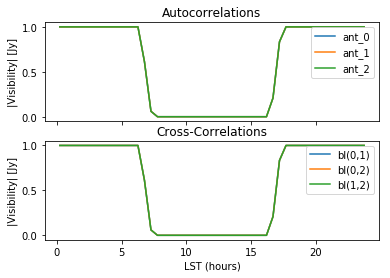

In [48]:
vis = simulator.simulate()
plot_blts(simulator)

In [14]:
point_source_pos = np.array([ # ra, dec
    (0, myuvdata().telescope_lat_lon_alt[0]),
    (0.1, myuvdata().telescope_lat_lon_alt[0])
]) 
point_source_flx = np.array([[1.0, 1.0]]*len(freqs))

In [15]:
simulator = VisCPU(
    uvdata = myuvdata(),
    point_source_pos=point_source_pos,
    point_source_flux = point_source_flx,
    sky_freqs = freqs,
)

invalid value encountered in sqrt


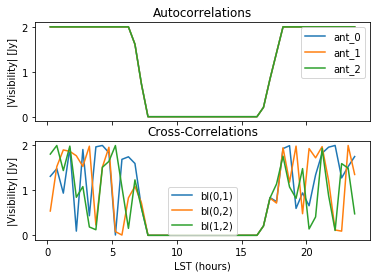

In [16]:
vis = simulator.simulate()
plot_blts(simulator)

In this, the beam was not set, and therefore the beam was assumed to be unity everywhere above the horizon. The beam can be set as a series of healpix maps, one for each antenna. 
An extra list of ``beam_ids`` specifies which of the beams each antenna uses. So, we can create something like a Gaussian beam:

In [17]:
simulator = VisCPU(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(6),
    sky_freqs = freqs,
    beams = [AnalyticBeam("gaussian", diameter=14)]
)

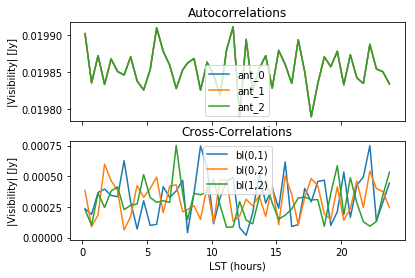

In [18]:
vis = simulator.simulate()
plot_blts(simulator)

## HealVis

We could also have used healvis for this:

In [9]:
simulator = HealVis(
    uvdata = myuvdata(),
    sky_freqs = freqs,
    sky_intensity = 100*uniform_sky(6),
)

In [10]:
vis = simulator.simulate()

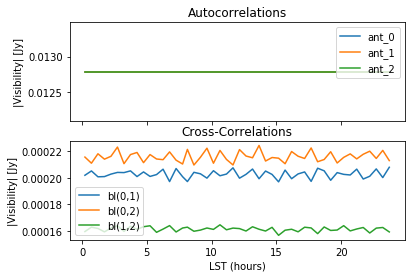

In [12]:
plot_blts(simulator)
fig = plt.gcf()

In [17]:
simulator = HealVis(
    uvdata = myuvdata(),
    point_source_pos=point_source_pos,
    point_source_flux = point_source_flx,
    sky_freqs = freqs,
)

This visibility simulator is unable to explicitly simulate point sources. Adding point sources to diffuse pixels


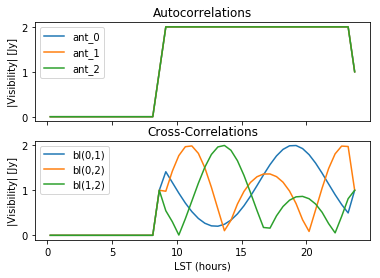

In [18]:
vis = simulator.simulate()
plot_blts(simulator)

## PRISim

In [9]:
simulator = PRISim(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(5),
    sky_freqs = freqs,
)

This visibility simulator is unable to explicitly simulate diffuse structure. Converting diffuse intensity to approximate points


In [10]:
vis = simulator.simulate()
plot_blts(simulator)

0.008682332764952437
0.0002214404787287254
0.010319212936635907
0.013630385731554128
0.010238587710908026
0.007923514830933924
0.009483336750670222
0.007166773790305907
0.0060713815745907845
0.017303315194097238
0.010002247825851067
0.018407979607417142
0.009325299622616471
0.0042082752938242375
0.004375590789313573
0.010288403383356827
0.01758356285390363
0.005728585902893907
0.0029156053030527382
0.013039663636658214
0.007575267650409972
0.013527384415313228
0.009195949060746025
0.02620236602205518
0.008549115050789554
-0.0019695489429111834
-0.004627313787278887


some sources are below horizon! Removing those sources manually. Minimum alt=-0.00196954894291
some sources are below horizon! Removing those sources manually. Minimum alt=-0.00462731378728


0.02664411676734557
-0.001109925783422897


some sources are below horizon! Removing those sources manually. Minimum alt=-0.00110992578342
some sources are below horizon! Removing those sources manually. Minimum alt=-0.000846072969977


-0.0008460729699767005
0.010369012525414074
0.018032219376103484
0.024077432295929038
-0.0022699441027883966
0.003874920995712924


some sources are below horizon! Removing those sources manually. Minimum alt=-0.00226994410279


0.012930351536335
0.012764148766539361
0.000918350571694764
0.0016239422075496304
0.030486550668514054
0.006000154376246267
-0.006814017272113618


some sources are below horizon! Removing those sources manually. Minimum alt=-0.00681401727211


-0.001508347373257339
0.005860221410220895


some sources are below horizon! Removing those sources manually. Minimum alt=-0.00150834737326


0.0195850927943739
0.0025986449579983094
0.00715438718904065
0.008242780626035649

Saving information about regions of interest...
	Created an extension for antenna element orientation.
		Created an extension HDU of 5 frequency channels
		Created HDU extensions for 48 observations containing ROI indices and primary beams
	Now writing FITS file to disk...


	Regions of interest information written successfully to FITS file on disk:
		prisim_roi_file.fits



AttributeError: 'UVData' object has no attribute 'get'

In [11]:
uv = myuvdata()

In [ ]:
uv.tel